## Exp-033 (ULMS BERT)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Wed Sep 15 23:28:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers pycld2

In [4]:
input_dir = "/content/drive/MyDrive/07_Competition/signate-471/data/"
output_dir = "/content/drive/MyDrive/07_Competition/signate-471/log/"
submission_dir = "/content/drive/MyDrive/07_Competition/signate-471/submission/"
model_dir = "/content/drive/MyDrive/07_Competition/signate-471/model_bin/"
pred_dir = "/content/drive/MyDrive/07_Competition/signate-471/pred/"

In [5]:
import os
import math
import random
import pandas as pd
import numpy as np
from glob import glob
import gc
gc.enable()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score

from transformers import BertConfig, RobertaConfig
from transformers import (get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup)
from transformers import BertTokenizer, RobertaTokenizer
from transformers import BertModel, RobertaModel
from transformers import AutoConfig, BertConfig, RobertaConfig
from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from torch import cuda
import time
import itertools

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import MODEL_FOR_SEQUENCE_CLASSIFICATION_MAPPING
from transformers import get_linear_schedule_with_warmup

from IPython.display import clear_output
from tqdm import tqdm, trange

import re
import nltk
import pycld2 as cld2
from scipy.optimize import minimize, minimize_scalar
import regex
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
class CFG:
  exp = "exp33h"
  seed = 71
  fold = 5
  max_len = 280
  epochs = 1
  lr = 2e-5
  train_batch_size = 16
  valid_batch_size = 32
  model_name = "GanjinZero/UMLSBert_ENG"

CONFIG = CFG()

In [7]:
os.makedirs(model_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(pred_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(output_dir+CONFIG.exp+"/", exist_ok=True)

In [8]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

set_random_seed(CONFIG.seed)

In [9]:
DEVICE = torch.device('cuda') if cuda.is_available() else 'cpu'

In [10]:
def init_logger(log_file=output_dir + CONFIG.exp+ f"/{CONFIG.exp}_train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [11]:
def get_train_data(train):
    # 交差検証 用の番号を振ります。
    Fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

def get_test_data(test):
    return test

In [12]:
class SRWSDataset(Dataset):
  def __init__(self, df, inference_only=False):

    # Berttokenizer
    tokenizer = BertTokenizer.from_pretrained(CONFIG.model_name)

    self.df = df
    self.inference_only = inference_only # "train":False or "test":True
    self.text = self.df["title_abst"].tolist() # text

    if not self.inference_only:
      # ここvalueだけ
      self.target = df["judgement"].values
      
    self.encoded = tokenizer.batch_encode_plus(
        self.text,
        padding = "max_length",
        max_length = CONFIG.max_len,
        truncation = True,
        return_attention_mask=True
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    input_ids = torch.tensor(self.encoded["input_ids"][index])
    attention_mask = torch.tensor(self.encoded["attention_mask"][index])

    # returnをsetかdictで返すかは自由
    if self.inference_only:
      return (input_ids, attention_mask)

    else:
      # ここで、tensor に変更している
      target = torch.tensor(self.target[index]).float()
      return (input_ids, attention_mask, target)


In [13]:
class SRWSBertModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.config = BertConfig.from_pretrained(CFG.model_name)
    self.config.update({"output_hidden_states": True})
    self.config.hidden_dropout_prob = 0
    self.config.attention_probs_dropout_prob = 0
    self.bert = BertModel.from_pretrained(CONFIG.model_name, config=self.config)
    self.regressor = nn.Linear(self.config.hidden_size*4, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask) 
    sequence_output = torch.cat([output["hidden_states"][-1*i][:,0] for i in range(1, 4+1)], dim=1)
    bert_output = self.regressor(sequence_output)
    bert_output = self.sigmoid(bert_output).squeeze()

    return bert_output

In [14]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [15]:
# 学習
def train_fn(model, train_loader, optimizer, epoch, loss_function, scheduler=None):
  start = end = time.time()
  losses = AverageMeter()
  model.train()

  for batch_num, (input_ids, attention_mask, target) in enumerate(train_loader):
    optimizer.zero_grad()

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    pred = model(input_ids, attention_mask)

    # Loss算出
    #print(pred)
    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)
    loss.backward()

    optimizer.step()

    if scheduler:
      scheduler.step()

    if batch_num % 100 == 0 or batch_num == (len(train_loader) -1):
      print(
            f"Epoch: [{epoch + 1}][{batch_num}/{len(train_loader)}] "
            f"Elapsed {timeSince(start, float(batch_num + 1) / len(train_loader)):s} "
            f"Loss: {losses.avg:.4f} "
            )
      
  return losses.avg

def valid_fn(valid_loader, model, loss_function):
  start = end = time.time()
  losses = AverageMeter()

  model.eval()
  preds = []

  for batch_num, (input_ids, attention_mask, target) in enumerate(valid_loader):
    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    # compare loss
    with torch.no_grad():
      pred = model(input_ids, attention_mask)

    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)

    # スコア追加
    preds.append(pred.to("cpu").numpy())

    if batch_num % 100 == 0 or batch_num == (len(valid_loader) - 1):
      print(
          f"EVAL: [{batch_num}/{len(valid_loader)}]"
          f"Elapsed {timeSince(start, float(batch_num+1) / len(valid_loader)):s}"
          f"Loss: {losses.avg:.4f}"
      )
  predictions = np.concatenate(preds)

  return losses.avg, predictions

# 予測
def inference():
    predictions = []

    test_dataset = SRWSDataset(test,  inference_only=True)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG.valid_batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    for fold in range(CONFIG.fold):
        LOGGER.info(f"========== model: {CONFIG.model_name} fold: {fold} inference ==========")
        model = SRWSBertModel()
        model.to(DEVICE)
        model.load_state_dict(torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")["model"])
        model.eval()
        preds = []
        for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            with torch.no_grad():
                y_preds = model(input_ids, attention_mask)
            preds.append(y_preds.to("cpu").numpy())
        preds = np.concatenate(preds)
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    return predictions

In [16]:
# 最適化（使ってない）
# https://signate.jp/competitions/471/discussions/tf-roberta-base-baseline-cv08949-lb08734

def opt_fbeta_threshold(y_true, y_pred):
  """fbeta score計算時のthresholdを最適化"""
  def opt_(x):
    return -fbeta_score(y_true, y_pred >= x, beta=7)
  result = minimize(opt_, x0=np.array([0.02]), method='Powell')
  best_threshold = result['x'].item()
  return best_threshold

In [17]:
def get_optimizer_grouped_parameters(model):
    model_type = 'bert'
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                       if 'lstm' in n
                       or 'cnn' in n
                       or 'regressor' in n],
            "weight_decay": 0.0,
            "lr": 1e-3,
        },
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = CONFIG.lr
    for layer in layers:
        lr *= 0.95
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.1,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [18]:
# LOOP
def train_loop(train, fold):
  LOGGER.info(f"========== fold: {fold} training ==========")

  # ====================================================
  # Data Loader
  # ====================================================
  trn_idx = train[train["fold"] != fold].index
  val_idx = train[train["fold"] == fold].index

  train_folds = train.loc[trn_idx].reset_index(drop=True)
  valid_folds = train.loc[val_idx].reset_index(drop=True)

  train_dataset = SRWSDataset(train_folds)
  valid_dataset = SRWSDataset(valid_folds)

  train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG.train_batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True, # https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587
        drop_last=True,
  )
  valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG.valid_batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
  )

  # ====================================================
  # Model
  # ====================================================
  model = SRWSBertModel()
  model.to(DEVICE)

  optimizer_parameters = get_optimizer_grouped_parameters(model)

  #optimizer = AdamW(model.parameters(), lr=CONFIG.lr)
  optimizer = AdamW(optimizer_parameters, lr=CONFIG.lr, weight_decay=0.1)

  # Loss_function
  loss_function = nn.BCELoss()

  # ====================================================
  # LOOP
  # ====================================================

  best_score = -1
  best_loss = np.inf
  best_borders=[]

  # 学習
  for epoch in range(CONFIG.epochs):
    start_time = time.time()

    # train
    avg_loss = train_fn(model, train_loader, optimizer, epoch, loss_function)

    # valid
    avg_val_loss, preds = valid_fn(valid_loader, model,loss_function)
    valid_labels = valid_folds["judgement"].values

    # border最適化
    border_m = opt_fbeta_threshold(valid_labels, preds)
    best_borders.append(border_m)

    # score
    score = fbeta_score(valid_labels, np.where(preds < border_m, 0, 1), beta=7.0)

    elapsed = time.time() - start_time
    LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
    )
    LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

    if score > best_score:
      best_score = score
      LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} ")
      torch.save(
                {"model": model.state_dict(), "preds": preds}, model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth"
      ) # scibertでの変更
  check_point = torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")

  valid_folds["preds"] = check_point["preds"]

  return valid_folds,best_borders

In [19]:
def get_result(result_df):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_threshold))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_threshold, 0, 1), beta=7.0)
    print("Score：" + str(score))
    LOGGER.info(f"Score: {score:<.5f}")

# inference用に、best_thresholdを出力するようにする関数
def get_result_for_cv(result_df,best_border):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    #best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_border))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_border, 0, 1), beta=7.0)
    LOGGER.info(f"Score: {score:<.5f}")

    return score

def mean_best_border(*best_borders):
    best_border = np.mean(best_borders)
    print("Best_Threshold：" + str(best_border))
    LOGGER.info(f"Best_Border: {best_border:<.8f}")

    return best_border

In [20]:
def clean_stopword(text):
  stopwords = nltk.corpus.stopwords.words('english')
  list_x = text.split()
  res = []
  for w in list_x:
    if w not in stopwords:
      res.append(w)
  return ' '.join(res)

def clean_puncts(x):
  # 化学式とかがあるから '-'は削除しないほうがいいか？

  puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
            '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
            '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
            '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
            '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '（', '）', '～',
            '➡', '％', '⇒', '▶', '「', '➄', '➆',  '➊', '➋', '➌', '➍', '⓪', '①', '②', '③', '④', '⑤', '⑰', '❶', '❷', '❸', '❹', '❺', '❻', '❼', '❽',  
            '＝', '※', '㈱', '､', '△', '℮', 'ⅼ', '‐', '｣', '┝', '↳', '◉', '／', '＋', '○',
            '【', '】', '✅', '☑', '➤', 'ﾞ', '↳', '〶', '☛', '｢', '⁺', '『', '≫',
            'Â©', '<sub>','Aﾎｲ', 'ﾎｲ', "ﾃｩ"
          ] 
  # 文字化け対応はここで対応するしかない？
  
  for punct in puncts:
    x = x.replace(punct, '')
  return x

def _pre_preprocess(x):
  return str(x).lower() 

def rm_num(x, use_num=True):
  numbers = ["0","1","2","3","4","5","6","7","8","9","０","１","２","３","４","５","６","７","８","９"]
  x = re.sub('[0-9]{5,}', '', x)
  x = re.sub('[0-9]{4}', '', x)
  x = re.sub('[0-9]{3}', '', x)
  x = re.sub('[0-9]{2}', '', x)    
  for i in numbers:
    x = x.replace(str(i), '')        
  return x

def convert_mojibake(text):
  text = text.encode("shift-jis").decode("utf-8", errors="ignore")
  return text

def remove_double(text):
  text = text.replace("  ", " ")
  return text

def preprocess_text(text):
  #text = _pre_preprocess(text)
  #text = clean_stopword(text)
  text = clean_puncts(text)
  text = rm_num(text)
  text = remove_double(text)

  return text

def split_copyright(text):
  if "Copyright" in text:
    text = text.split('Copyright')[0]
    return text
  else:
    return text


In [48]:
pd.set_option("display.max_colwidth", 50)
train = pd.read_csv(input_dir + "train.csv")
test = pd.read_csv(input_dir + "test.csv")
sub = pd.read_csv(input_dir + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

In [49]:
# ラベル変更
# https://signate.jp/competitions/471/discussions/20210816152356-59

train.loc[train["id"]==2488, "judgement"] = 0
train.loc[train["id"]==7708, "judgement"] = 0

In [50]:
train["title_abst"] = train["title"] + train["abstract"]
train["title_abst"].fillna(train["title"], inplace=True)

test["title_abst"] = test["title"] + test["abstract"]
test["title_abst"].fillna(test["title"], inplace=True)

train.head()

,id,title,abstract,judgement,title_abst
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,One-year age changes in MRI brain volumes in o...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,Supportive CSF biomarker evidence to enhance t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,Occurrence of basal ganglia germ cell tumors w...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,New developments in diagnosis and therapy of C...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,Prolonged shedding of SARS-CoV-2 in an elderly...


In [51]:
# preprocess
train["title_abst"] = train["title_abst"].apply(lambda x: preprocess_text(x))
test["title_abst"] = test["title_abst"].apply(lambda x: preprocess_text(x))

# titleの単語数が3以下のものは除外してみる
train["title_word_len"] = train["title"].str.split(" ").str.len()
train = train[train["title_word_len"]>3]

# titleが他言語の場合は除外
train["title_lang"] = train["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
train = train[(train["title_lang"]=="en")|(train["title_lang"]=="un")]

# copyright以降は削除したい
train["title_abst"] = train["title_abst"].apply(lambda x: split_copyright(x))
test["title_abst"] = test["title_abst"].apply(lambda x: split_copyright(x))

train = train[["id","title","abstract","title_abst","judgement"]]

In [52]:
train

,id,title,abstract,title_abst,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,Oneyear age changes in MRI brain volumes in ol...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,Supportive CSF biomarker evidence to enhance t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,Occurrence of basal ganglia germ cell tumors w...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,New developments in diagnosis and therapy of C...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,Prolonged shedding of SARSCoV in an elderly li...,0
...,...,...,...,...,...
27140,27140,The amyloidogenic pathway of amyloid precursor...,Amyloid beta-protein (A beta) is the main cons...,The amyloidogenic pathway of amyloid precursor...,0
27141,27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,Technologic developments in radiotherapy and s...,0
27142,27142,Novel screening cascade identifies MKK4 as key...,Phosphorylation of Tau at serine 422 promotes ...,Novel screening cascade identifies MKK as key ...,0
27143,27143,Visualization of the gall bladder on F-18 FDOP...,The ability to label dihydroxyphenylalanine (D...,Visualization of the gall bladder on F FDOPA P...,0


In [53]:
#Judgement==1 Sampleのオーバーサンプリング
# title, abstのランダムな組み合わせでデータを水増し
index_list = list(train[train.judgement==1].index)
combination_list = list(itertools.combinations(index_list, 2))

select_num = train.judgement.value_counts()[1]
random.seed(CONFIG.seed)
selected_samples = random.sample(combination_list,select_num)
add_df = pd.DataFrame(selected_samples)
add_df.columns=["title_index","abst_index"]

positive_titles = pd.DataFrame(train[train.judgement==1].title)
positive_abstracts = pd.DataFrame(train[train.judgement==1].abstract)

additional_df = pd.merge(add_df,positive_titles,left_on="title_index",right_on=positive_titles.index,how="left")
additional_df = pd.merge(additional_df,positive_abstracts,left_on="abst_index",right_on=positive_abstracts.index,how="left")
additional_df["title_abst"] = additional_df["title"] + additional_df["abstract"]
additional_df["title_abst"].fillna(additional_df["title"], inplace=True)
additional_df["judgement"] =1
additional_df["id"] =additional_df.index

additional_df = additional_df[["id","title","abstract","title_abst","judgement"]]

In [54]:
additional_df

,id,title,abstract,title_abst,judgement
0,0,Chest CT in patients with a moderate or high p...,The COVID-19 infection is increasing at a rapi...,Chest CT in patients with a moderate or high p...,1
1,1,Coronavirus disease 2019 (COVID-19): chest CT ...,NaN,Coronavirus disease 2019 (COVID-19): chest CT ...,1
2,2,Utility of the FebriDx point-of-care test for ...,BACKGROUND: Comparative data of SARS-CoV-2 IgM...,Utility of the FebriDx point-of-care test for ...,1
3,3,Title: Utility of Repeat Testing for COVID-19:...,Purpose To present a method that automatically...,Title: Utility of Repeat Testing for COVID-19:...,1
4,4,Brief clinical evaluation of six high-throughp...,PURPOSE: 3'-Deoxy-3'-[18F]fluorothymidine ([18...,Brief clinical evaluation of six high-throughp...,1
...,...,...,...,...,...
619,619,Comparative performance of five commercially a...,BACKGROUND: As the COVID-19 pandemic continues...,Comparative performance of five commercially a...,1
620,620,[Chronic bird-related hypersensitivity pneumon...,Fluctuations in mental status are 1 of the cor...,[Chronic bird-related hypersensitivity pneumon...,1
621,621,Inhalation provocation tests in bird-related h...,NaN,Inhalation provocation tests in bird-related h...,1
622,622,Usefulness of portable chest radiography in in...,NaN,Usefulness of portable chest radiography in in...,1


In [55]:
train = pd.concat([train,additional_df],axis=0).reset_index(drop=True)
train["id"] = train.index

In [56]:
train

,id,title,abstract,title_abst,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,Oneyear age changes in MRI brain volumes in ol...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,Supportive CSF biomarker evidence to enhance t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,Occurrence of basal ganglia germ cell tumors w...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,New developments in diagnosis and therapy of C...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,Prolonged shedding of SARSCoV in an elderly li...,0
...,...,...,...,...,...
27540,27540,Comparative performance of five commercially a...,BACKGROUND: As the COVID-19 pandemic continues...,Comparative performance of five commercially a...,1
27541,27541,[Chronic bird-related hypersensitivity pneumon...,Fluctuations in mental status are 1 of the cor...,[Chronic bird-related hypersensitivity pneumon...,1
27542,27542,Inhalation provocation tests in bird-related h...,NaN,Inhalation provocation tests in bird-related h...,1
27543,27543,Usefulness of portable chest radiography in in...,NaN,Usefulness of portable chest radiography in in...,1


In [57]:
train.judgement.value_counts()

0    26297
1     1248
Name: judgement, dtype: int64

In [58]:
train = get_train_data(train)
train.head()

,id,title,abstract,title_abst,judgement,fold
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,Oneyear age changes in MRI brain volumes in ol...,0,4
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,Supportive CSF biomarker evidence to enhance t...,0,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,Occurrence of basal ganglia germ cell tumors w...,0,2
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,New developments in diagnosis and therapy of C...,0,1
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,Prolonged shedding of SARSCoV in an elderly li...,0,0


In [59]:
train[train.fold==4].judgement.value_counts()

0    5259
1     250
Name: judgement, dtype: int64

In [60]:
train[train.fold==3].judgement.value_counts()

0    5259
1     250
Name: judgement, dtype: int64

In [61]:
train[train.fold==1].judgement.value_counts()

0    5260
1     249
Name: judgement, dtype: int64

In [62]:
train[train.fold==0].judgement.value_counts()

0    5260
1     249
Name: judgement, dtype: int64

In [63]:
# Training
#border = len(train[train["judgement"] == 1]) / len(train["judgement"]) # 0.023245467689912133
#border = border * 0.6

mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df.csv", index=False)

========== fold: 0 training ==========


Epoch: [1][0/1377] Elapsed 0m 0s (remain 14m 56s) Loss: 1.0732 
Epoch: [1][100/1377] Elapsed 0m 43s (remain 9m 5s) Loss: 0.1301 
Epoch: [1][200/1377] Elapsed 1m 25s (remain 8m 21s) Loss: 0.1093 
Epoch: [1][300/1377] Elapsed 2m 8s (remain 7m 38s) Loss: 0.0953 
Epoch: [1][400/1377] Elapsed 2m 50s (remain 6m 55s) Loss: 0.0868 
Epoch: [1][500/1377] Elapsed 3m 33s (remain 6m 13s) Loss: 0.0801 
Epoch: [1][600/1377] Elapsed 4m 16s (remain 5m 30s) Loss: 0.0774 
Epoch: [1][700/1377] Elapsed 4m 58s (remain 4m 47s) Loss: 0.0735 
Epoch: [1][800/1377] Elapsed 5m 41s (remain 4m 5s) Loss: 0.0685 
Epoch: [1][900/1377] Elapsed 6m 23s (remain 3m 22s) Loss: 0.0661 
Epoch: [1][1000/1377] Elapsed 7m 6s (remain 2m 40s) Loss: 0.0636 
Epoch: [1][1100/1377] Elapsed 7m 48s (remain 1m 57s) Loss: 0.0627 
Epoch: [1][1200/1377] Elapsed 8m 31s (remain 1m 14s) Loss: 0.0605 
Epoch: [1][1300/1377] Elapsed 9m 14s (remain 0m 32s) Loss: 0.0604 
Epoch: [1][1376/1377] Elapsed 9m 46s (remain 0m 0s) Loss: 0.0587 
EVAL: [0/173

Epoch 1 - avg_train_loss: 0.0587  avg_val_loss: 0.0483  time: 635s
Epoch 1 - Score: 0.9641873278236915
Epoch 1 - Save Best Score: 0.9642 


EVAL: [172/173]Elapsed 0m 48s (remain 0m 0s)Loss: 0.0483


========== fold: 0 result ==========
Best_Border: 0.03254368
========== fold: 1 training ==========


Best_Threshold：0.03254368174626218
Epoch: [1][0/1377] Elapsed 0m 0s (remain 13m 39s) Loss: 0.6670 
Epoch: [1][100/1377] Elapsed 0m 43s (remain 9m 4s) Loss: 0.1189 
Epoch: [1][200/1377] Elapsed 1m 25s (remain 8m 21s) Loss: 0.0964 
Epoch: [1][300/1377] Elapsed 2m 8s (remain 7m 38s) Loss: 0.0882 
Epoch: [1][400/1377] Elapsed 2m 50s (remain 6m 55s) Loss: 0.0813 
Epoch: [1][500/1377] Elapsed 3m 33s (remain 6m 13s) Loss: 0.0760 
Epoch: [1][600/1377] Elapsed 4m 15s (remain 5m 30s) Loss: 0.0746 
Epoch: [1][700/1377] Elapsed 4m 58s (remain 4m 47s) Loss: 0.0701 
Epoch: [1][800/1377] Elapsed 5m 41s (remain 4m 5s) Loss: 0.0684 
Epoch: [1][900/1377] Elapsed 6m 23s (remain 3m 22s) Loss: 0.0663 
Epoch: [1][1000/1377] Elapsed 7m 6s (remain 2m 40s) Loss: 0.0638 
Epoch: [1][1100/1377] Elapsed 7m 48s (remain 1m 57s) Loss: 0.0629 
Epoch: [1][1200/1377] Elapsed 8m 31s (remain 1m 14s) Loss: 0.0608 
Epoch: [1][1300/1377] Elapsed 9m 13s (remain 0m 32s) Loss: 0.0590 
Epoch: [1][1376/1377] Elapsed 9m 46s (remai

Epoch 1 - avg_train_loss: 0.0590  avg_val_loss: 0.0351  time: 635s
Epoch 1 - Score: 0.9374754844277086
Epoch 1 - Save Best Score: 0.9375 


EVAL: [172/173]Elapsed 0m 48s (remain 0m 0s)Loss: 0.0351


========== fold: 1 result ==========
Best_Border: 0.01807878
========== fold: 2 training ==========


Best_Threshold：0.018078780349185402
Epoch: [1][0/1377] Elapsed 0m 0s (remain 14m 0s) Loss: 0.4691 
Epoch: [1][100/1377] Elapsed 0m 43s (remain 9m 5s) Loss: 0.1109 
Epoch: [1][200/1377] Elapsed 1m 25s (remain 8m 21s) Loss: 0.0925 
Epoch: [1][300/1377] Elapsed 2m 8s (remain 7m 38s) Loss: 0.0802 
Epoch: [1][400/1377] Elapsed 2m 50s (remain 6m 55s) Loss: 0.0752 
Epoch: [1][500/1377] Elapsed 3m 33s (remain 6m 13s) Loss: 0.0723 
Epoch: [1][600/1377] Elapsed 4m 16s (remain 5m 30s) Loss: 0.0690 
Epoch: [1][700/1377] Elapsed 4m 58s (remain 4m 47s) Loss: 0.0650 
Epoch: [1][800/1377] Elapsed 5m 41s (remain 4m 5s) Loss: 0.0629 
Epoch: [1][900/1377] Elapsed 6m 23s (remain 3m 22s) Loss: 0.0604 
Epoch: [1][1000/1377] Elapsed 7m 6s (remain 2m 40s) Loss: 0.0600 
Epoch: [1][1100/1377] Elapsed 7m 48s (remain 1m 57s) Loss: 0.0578 
Epoch: [1][1200/1377] Elapsed 8m 31s (remain 1m 14s) Loss: 0.0580 
Epoch: [1][1300/1377] Elapsed 9m 13s (remain 0m 32s) Loss: 0.0587 
Epoch: [1][1376/1377] Elapsed 9m 46s (remai

Epoch 1 - avg_train_loss: 0.0588  avg_val_loss: 0.0418  time: 635s
Epoch 1 - Score: 0.9428153621180635
Epoch 1 - Save Best Score: 0.9428 
========== fold: 2 result ==========
Best_Border: 0.00413303
========== fold: 3 training ==========


Best_Threshold：0.0041330333803512075
Epoch: [1][0/1377] Elapsed 0m 1s (remain 28m 46s) Loss: 1.2705 
Epoch: [1][100/1377] Elapsed 0m 43s (remain 9m 13s) Loss: 0.1207 
Epoch: [1][200/1377] Elapsed 1m 26s (remain 8m 25s) Loss: 0.0951 
Epoch: [1][300/1377] Elapsed 2m 8s (remain 7m 40s) Loss: 0.0831 
Epoch: [1][400/1377] Elapsed 2m 51s (remain 6m 57s) Loss: 0.0757 
Epoch: [1][500/1377] Elapsed 3m 33s (remain 6m 14s) Loss: 0.0720 
Epoch: [1][600/1377] Elapsed 4m 16s (remain 5m 31s) Loss: 0.0688 
Epoch: [1][700/1377] Elapsed 4m 59s (remain 4m 48s) Loss: 0.0671 
Epoch: [1][800/1377] Elapsed 5m 41s (remain 4m 5s) Loss: 0.0646 
Epoch: [1][900/1377] Elapsed 6m 24s (remain 3m 22s) Loss: 0.0626 
Epoch: [1][1000/1377] Elapsed 7m 6s (remain 2m 40s) Loss: 0.0613 
Epoch: [1][1100/1377] Elapsed 7m 49s (remain 1m 57s) Loss: 0.0596 
Epoch: [1][1200/1377] Elapsed 8m 31s (remain 1m 15s) Loss: 0.0595 
Epoch: [1][1300/1377] Elapsed 9m 14s (remain 0m 32s) Loss: 0.0587 
Epoch: [1][1376/1377] Elapsed 9m 46s (re

Epoch 1 - avg_train_loss: 0.0579  avg_val_loss: 0.0440  time: 635s
Epoch 1 - Score: 0.9657663316582915
Epoch 1 - Save Best Score: 0.9658 


EVAL: [172/173]Elapsed 0m 48s (remain 0m 0s)Loss: 0.0440


========== fold: 3 result ==========
Best_Border: 0.05872626
========== fold: 4 training ==========


Best_Threshold：0.05872625905758973
Epoch: [1][0/1377] Elapsed 0m 0s (remain 14m 0s) Loss: 0.5846 
Epoch: [1][100/1377] Elapsed 0m 43s (remain 9m 5s) Loss: 0.1215 
Epoch: [1][200/1377] Elapsed 1m 25s (remain 8m 21s) Loss: 0.0910 
Epoch: [1][300/1377] Elapsed 2m 8s (remain 7m 38s) Loss: 0.0880 
Epoch: [1][400/1377] Elapsed 2m 50s (remain 6m 55s) Loss: 0.0827 
Epoch: [1][500/1377] Elapsed 3m 33s (remain 6m 13s) Loss: 0.0783 
Epoch: [1][600/1377] Elapsed 4m 15s (remain 5m 30s) Loss: 0.0743 
Epoch: [1][700/1377] Elapsed 4m 58s (remain 4m 47s) Loss: 0.0725 
Epoch: [1][800/1377] Elapsed 5m 41s (remain 4m 5s) Loss: 0.0698 
Epoch: [1][900/1377] Elapsed 6m 23s (remain 3m 22s) Loss: 0.0675 
Epoch: [1][1000/1377] Elapsed 7m 6s (remain 2m 40s) Loss: 0.0652 
Epoch: [1][1100/1377] Elapsed 7m 48s (remain 1m 57s) Loss: 0.0651 
Epoch: [1][1200/1377] Elapsed 8m 31s (remain 1m 14s) Loss: 0.0629 
Epoch: [1][1300/1377] Elapsed 9m 13s (remain 0m 32s) Loss: 0.0608 
Epoch: [1][1376/1377] Elapsed 9m 46s (remain

Epoch 1 - avg_train_loss: 0.0592  avg_val_loss: 0.0457  time: 635s
Epoch 1 - Score: 0.9562949498142732
Epoch 1 - Save Best Score: 0.9563 


EVAL: [172/173]Elapsed 0m 48s (remain 0m 0s)Loss: 0.0457


========== fold: 4 result ==========
Best_Border: 0.00805666
========== CV ==========
Best_Border: 0.02430768
Score: 0.94213


Best_Threshold：0.00805665591588068
Best_Threshold：0.024307682089853837
Best_Threshold：0.024307682089853837


In [64]:
best_border

0.024307682089853837

In [65]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df.csv", index=False)

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission.csv", index=False, header=False)

========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
100%|██████████| 1277/1277 [05:58<00:00,  3.56it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [05:58<00:00,  3.56it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [05:58<00:00,  3.56it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [05:58<00:00,  3.56it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 4 inference ==========
100%|██████████| 1277/1277 [05:58<00:00,  3.56it/s]


In [66]:
pred_df=pd.read_csv(pred_dir +CONFIG.exp + "/pred_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


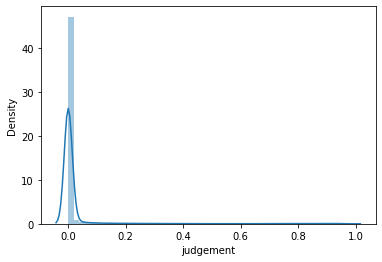

In [72]:
import seaborn as sns
sns.distplot(pred_df["judgement"])

In [68]:
oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


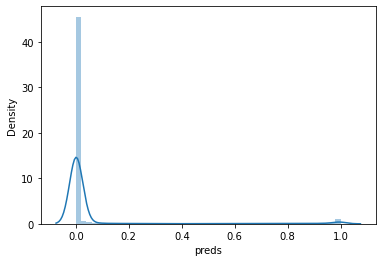

In [69]:
import seaborn as sns
sns.distplot(oof_df["preds"])